In [1]:
import re
import time
import math
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing 
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA


In [20]:
# Load data
arrivals = pd.read_csv('C:/Users/keith/Desktop/Thinkful/2008.csv',encoding = "ISO-8859-1")

pd.set_option('display.max_columns', None) # disables trucated columns 
pd.set_option('display.max_rows', None) # disables trucated rows


In [35]:
pd.set_option('display.max_columns',50) # disables trucated columns 
pd.set_option('display.max_rows',50)

In [21]:
# dropping 'CancellationCode','Cancelled' columns

variables_to_remove = ['CancellationCode','Cancelled','Diverted','FlightNum','TailNum']
arrivals = arrivals.drop(variables_to_remove, 1)

In [22]:
arrivals.fillna({'CarrierDelay':0,
       'WeatherDelay':0, 'NASDelay':0, 'SecurityDelay':0, 'LateAircraftDelay':0}, inplace=True)

In [23]:
arrivals.dropna(inplace=True)

In [24]:
arrivals['Late_arrivals'] = np.where(arrivals['ArrDelay']>30, 1, 0)
arrivals['Late_departures'] = np.where(arrivals['DepDelay']>30, 1, 0)

In [25]:
len(arrivals)

6855029

In [26]:
arrivals['Day'] = arrivals['DayofMonth'] 
arrivals['date'] = pd.to_datetime(arrivals[['Year','Month','Day']])
arrivals = arrivals.drop(['Year','DayofMonth','Day','Month'],1)

In [9]:
arr_samp = arrivals.sample(frac=.01)

In [27]:
bins=['2008-01-01','2008-03-19','2008-06-01','2008-09-23','2008-12-21','2008-12-31']
bin_names = ['winter','spring','summer','fall','Winter']
arrivals['seasons'] = pd.cut(arrivals.date, pd.to_datetime(bins),labels=bin_names)
arrivals['seasons'] = arrivals['seasons'].str.lower()


bins=[0,600,1159,1700,2000,2359]
bin_names = ['night','morning','afternoon','evening','Night']
arrivals['time_of_day'] = pd.cut(arrivals.ArrTime, bins,labels=bin_names)
arrivals['time_of_day'] = arrivals['time_of_day'].str.lower()

In [28]:
arrivals.seasons.value_counts()

summer    2198147
winter    1647780
fall      1552056
spring    1438449
Name: seasons, dtype: int64

In [29]:
arrivals['seasons'] = arrivals.seasons.astype('category')
arrivals['time_of_day'] = arrivals.seasons.astype('category')

In [13]:
from sklearn import preprocessing 
  
# label_encoder object  
label_encoder = preprocessing.LabelEncoder() 

arrivals['seasons'] = arrivals.seasons.astype(str)
arrivals['time_of_day'] = arrivals.seasons.astype(str)
  
# Encode labels in column  
arrivals['seasons']= label_encoder.fit_transform(arrivals['seasons']) 
arrivals['time_of_day']= label_encoder.fit_transform(arrivals['time_of_day']) 
arrivals['seasons']= label_encoder.inverse_transform(arrivals['seasons']) 
arrivals['time_of_day']= label_encoder.inverse_transform(arrivals['time_of_day']) 
 
print(arrivals['seasons'].unique())
print(arrivals['time_of_day'].unique()) 

['winter' 'nan' 'spring' 'summer' 'fall']
['winter' 'nan' 'spring' 'summer' 'fall']


In [36]:
arrivals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6855029 entries, 0 to 7009727
Data columns (total 26 columns):
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
Late_arrivals        int32
Late_departures      int32
date                 datetime64[ns]
seasons              category
time_of_day          category
dtypes: category(2), datetime64[ns](1), float64(14), int32(2), int64(4), object(3)
memory usage: 1.2+ GB


In [31]:
arr_samp = arrivals.sample(frac=.01)
len(arr_samp)

68550

In [33]:
arr_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68550 entries, 1951077 to 6572831
Data columns (total 26 columns):
DayOfWeek            68550 non-null int64
DepTime              68550 non-null float64
CRSDepTime           68550 non-null int64
ArrTime              68550 non-null float64
CRSArrTime           68550 non-null int64
UniqueCarrier        68550 non-null object
ActualElapsedTime    68550 non-null float64
CRSElapsedTime       68550 non-null float64
AirTime              68550 non-null float64
ArrDelay             68550 non-null float64
DepDelay             68550 non-null float64
Origin               68550 non-null object
Dest                 68550 non-null object
Distance             68550 non-null int64
TaxiIn               68550 non-null float64
TaxiOut              68550 non-null float64
CarrierDelay         68550 non-null float64
WeatherDelay         68550 non-null float64
NASDelay             68550 non-null float64
SecurityDelay        68550 non-null float64
LateAircraftDe

In [37]:
arr_samp.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Late_arrivals,Late_departures,date,seasons,time_of_day
1951077,3,1959.0,2000,2055.0,2106,OH,56.0,66.0,45.0,-11.0,-1.0,CVG,GRR,268,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0,0,2008-04-23,spring,spring
265696,2,1858.0,1905,2353.0,11,US,175.0,186.0,149.0,-18.0,-7.0,LAS,MSP,1300,4.0,22.0,0.0,0.0,0.0,0.0,0.0,0,0,2008-01-08,winter,winter
5848521,3,1117.0,1125,1332.0,1330,AA,195.0,185.0,173.0,2.0,-8.0,IAD,DFW,1172,11.0,11.0,0.0,0.0,0.0,0.0,0.0,0,0,2008-10-15,fall,fall
1254438,3,1621.0,1620,1743.0,1750,WN,82.0,90.0,62.0,-7.0,1.0,SFO,LAS,414,5.0,15.0,0.0,0.0,0.0,0.0,0.0,0,0,2008-03-26,spring,spring
3450852,1,1835.0,1715,2003.0,1826,NW,88.0,71.0,50.0,97.0,80.0,MSP,MKE,297,7.0,31.0,68.0,0.0,17.0,0.0,12.0,1,1,2008-06-02,summer,summer


### Preprocessing

In [38]:
features =  ['DayOfWeek', 'DepTime', 'CRSDepTime',   'CRSArrTime',
             'ActualElapsedTime','CRSElapsedTime', 'AirTime','DepDelay',  
             'Distance', 'TaxiIn', 'TaxiOut',   'CarrierDelay','WeatherDelay',
             'NASDelay', 'SecurityDelay', 'LateAircraftDelay','Late_arrivals', 
             'Late_departures', 'seasons', 'time_of_day']

Y = arr_samp['ArrDelay'] 
X = pd.get_dummies(arr_samp[features],drop_first=True)
     


from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)

 # Automatic feature selection with SelectKbest
import sklearn.feature_selection 
select =sklearn.feature_selection.SelectKBest()
selected_features = select.fit(X_train, y_train)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indicies_selected]
X_selected = X[colnames_selected]
print(colnames_selected)
x_train_selected = X_train[colnames_selected]
x_test_selected = X_test[colnames_selected]

X = arrivals[colnames_selected]
Y = arrivals['ArrDelay']

# Standardizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train_selected) 
X_train = scaler.transform(x_train_selected)
X_test = scaler.transform(x_test_selected)


C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


['DepTime', 'DepDelay', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'Late_arrivals', 'Late_departures']


# MODELING

### Linear regression

In [40]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()

regr.fit(X_train,y_train)

print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X_test, y_test).score(X_test, y_test)))
print()
from sklearn.model_selection import cross_val_score
print(cross_val_score(regr, X_train, y_train, cv=10))

 
 
 
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))

With 20% Holdout: 0.9573081910932117
Testing on Sample: 0.95732386640617

[0.95106992 0.95790445 0.95374443 0.95310507 0.96415138 0.95415976
 0.95863669 0.95275838 0.95416954 0.96526069]

Coefficients: 
 [-0.11820899 14.99270163  1.78963425  3.87529857 12.08130271  5.81973491
 10.7181979  12.13749047  1.5758859  -1.04119256]

Intercept: 
 8.302279305623575

R-squared:
0.95732386640617


In [55]:
print(list(regr.predict(X_test)))
y_test 

[11.938948944757968, 18.409289137841057, -3.284922994024079, -9.047308737429105, -6.158290816070082, -10.432291476609102, -4.50624405878796, 15.011037171003561, 5.3469556835033085, -1.7185951565243585, -8.844527538024742, -8.183272287146501, -6.805778200643381, -1.664037008514562, -6.498067311529134, 23.138594412353577, -1.2493706093289099, -0.10997939471281448, -4.978943652641792, -1.7767323531799377, -1.4379440013713811, -7.966021024827782, -8.867024298550461, -3.282247677969309, -6.027981671145952, -6.370105179309924, 56.58808814358285, -2.7135037010508007, -2.135807042974699, -6.804295922718978, -6.050203229845206, 223.42464397163724, -6.918459507341183, -9.086477428174533, 174.6160013660001, -5.394500091600403, -7.667652596623505, 24.590642169334227, 58.35200170560449, 1.7736454566733766, 76.1722408730901, -4.071830693265591, -7.892941301768211, -8.78800031276959, -2.00603282320251, 0.7428312699581809, -9.152043594172003, -7.280938341507563, -3.334599508481915, 12.641295851964427,

4957006     17.0
3743620     24.0
4594887     -3.0
6578630    -24.0
4114115     -7.0
5981471    -32.0
5355838     -8.0
6540808     17.0
1164417      0.0
488640     -28.0
6957973    -28.0
4015176     -9.0
6079341    -11.0
1448502     -3.0
5975870      5.0
6776343     26.0
5677125      3.0
2859435     -2.0
425117      -2.0
909642       7.0
519626       7.0
6337500    -12.0
3873876    -13.0
955857       7.0
5132049     -8.0
           ...  
4542400    -14.0
4406260    -14.0
4842377      3.0
924685     -10.0
2467865    116.0
4122894    -18.0
4598314    -12.0
3948074     -3.0
2688392      7.0
1495925     -6.0
1016417     -8.0
6680409    114.0
1393680    -16.0
3160954    -31.0
3053673      8.0
2239009     39.0
5611298    -10.0
5661309    -18.0
5679949      1.0
1552472    -13.0
5840561     -4.0
2100628     -5.0
6966022      7.0
3438130     23.0
4750746      1.0
Name: ArrDelay, Length: 13710, dtype: float64

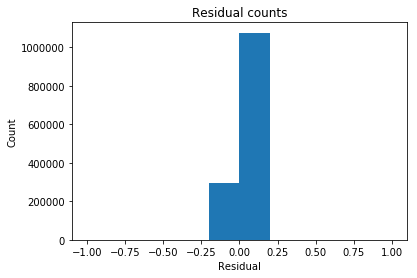

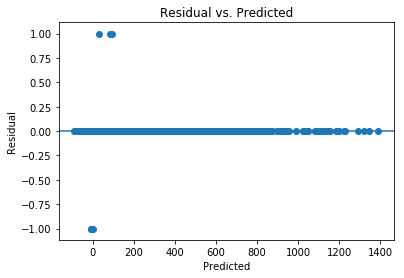

RMSE: 0.002091957014178272


In [33]:
predicted = regr.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  


In [239]:
# Tuning hyperparameters
param_grid = dict(normalize=[True,False],copy_X=[True,False])
grid = GridSearchCV(regr, param_grid, cv=5, scoring="r2", return_train_score=True)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'copy_X': True, 'normalize': True}
0.9988254755673102


In [34]:
# Instantiate and fit our model.
 
regr = linear_model.LinearRegression(copy_X=True, normalize=True) 
regr.fit(X_train,y_train)


print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit( X_test , y_test).score(X_test, y_test)))
print()
from sklearn.model_selection import cross_val_score
print(cross_val_score(regr, X_test, y_test, cv=10))
 
 
 
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))


With 20% Holdout: 0.999999997048333
Testing on Sample: 0.9999999970483635

[1.         0.99999999 0.99999999 1.         1.         1.
 1.         1.         1.         1.        ]

Coefficients: 
 [-1.92561047e-06 -2.30257948e-06  7.01957225e+01 -6.95442490e+01
  3.52135116e+01  7.15123074e-07 -2.28519564e-07 -1.73735923e-07
  9.00286581e-06]

Intercept: 
 8.155082313117669

R-squared:
0.9999999970483635


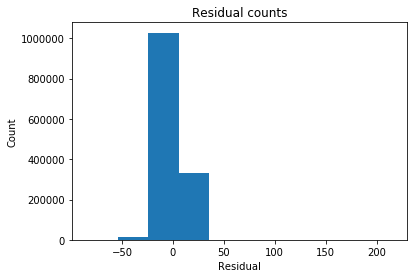

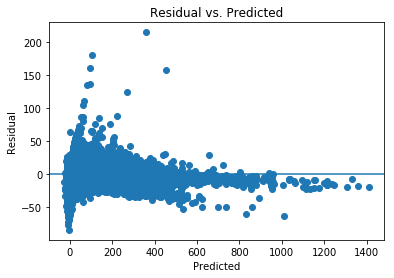

RMSE: 8.263887058520421


In [19]:
predicted = regr.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  
 

 ### KNN regression
 

In [ ]:
from sklearn import neighbors
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10) 
knn.fit(X_train, y_train)


print('With 20% Holdout: ' + str(knn.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(knn.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(knn, X_test, y_test, cv=10))

 

In [ ]:
param_grid = dict(leaf_size=range(1,30),p=(1,2),n_neighbors=range(1,12),weights=['distance','uniform'])
grid = GridSearchCV(knn, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

In [ ]:
#fit with new parameters
knn = neighbors.KNeighborsRegressor(n_neighbors=1,p=1,leaf_size=1,weights='distance') 
knn.fit(X_train, y_train)


print('With 20% Holdout: ' + str(knn.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(knn.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(knn, X_test, y_test, cv=10))

In [ ]:
predicted = knn.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  
 

### Decision Trees

In [30]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression tree model
regr_t = DecisionTreeRegressor(max_depth=2,random_state=20) 
regr_t.fit(X_train, y_train)


print('With 20% Holdout: ' + str(regr_t.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr_t.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(regr_t, X_test, y_test, cv=10))

 

With 20% Holdout: 0.7639949575145674
Testing on Sample: 0.7640757602834478

[0.76833003 0.76420115 0.7581803  0.76068991 0.76873021 0.75409107
 0.77119527 0.76507335 0.75975095 0.77125007]


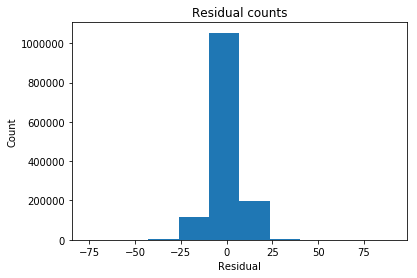

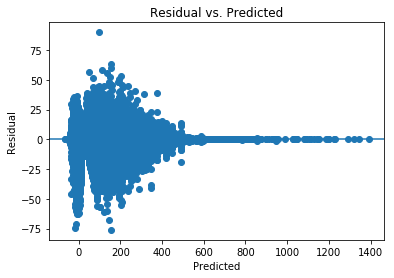

RMSE: 7.422066187547405


In [41]:
predicted = regr_t.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  
 

In [36]:
param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(6,20),max_features=['sqrt',4])
grid = GridSearchCV(regr_t, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'max_depth': 15}
0.9607028641769348


In [38]:
regr_t = DecisionTreeRegressor(max_depth=15, random_state=20) 
regr_t.fit(X_train, y_train)


print('With 20% Holdout: ' + str(regr_t.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr_t.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(regr_t, X_test, y_test, cv=10))

 

With 20% Holdout: 0.9611891002965023
Testing on Sample: 0.9628458776260728

[0.95896373 0.95824178 0.96034944 0.96115901 0.95975676 0.96085604
 0.95880463 0.95899422 0.95971846 0.9595333 ]


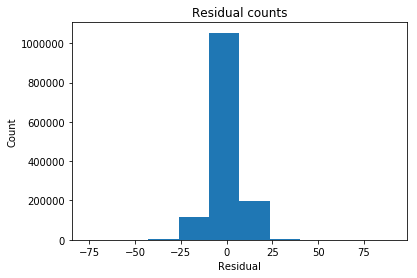

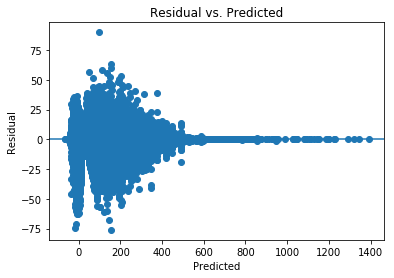

RMSE: 7.422066187547405


In [42]:
predicted = regr_t.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  
 

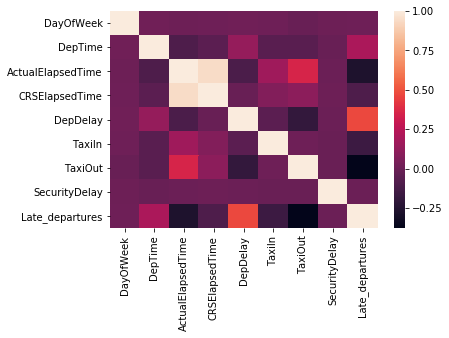

In [26]:
sns.heatmap(arrivals[arrivals.Late_arrivals==1][features].corr())

In [36]:
arrivals.DayOfWeek.value_counts()

3    1016995
1    1013410
4    1011970
5    1008872
2    1005992
7     956127
6     841663
Name: DayOfWeek, dtype: int64

In [50]:
arr = arrivals.sample(frac=.0003)
len(arr)

2057

In [29]:
features =  ['DayOfWeek', 'DepTime','ActualElapsedTime','CRSElapsedTime','DepDelay',
             'TaxiIn', 'TaxiOut','SecurityDelay','Late_departures' ]

Y = arrivals['ArrDelay'] 
X = arrivals[features]



from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)

 # Automatic feature selection with SelectKbest
import sklearn.feature_selection 
select =sklearn.feature_selection.SelectKBest(k="all")
selected_features = select.fit(X_train, y_train)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indicies_selected]
X_selected = X[colnames_selected]
print(colnames_selected)
x_train_selected = X_train[colnames_selected]
x_test_selected = X_test[colnames_selected]

X = arrivals[colnames_selected]
Y = arrivals['ArrDelay']

# Standardizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train_selected) 
X_train = scaler.transform(x_train_selected)
X_test = scaler.transform(x_test_selected)


['DayOfWeek', 'DepTime', 'ActualElapsedTime', 'CRSElapsedTime', 'DepDelay', 'TaxiIn', 'TaxiOut', 'SecurityDelay', 'Late_departures']


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.


### Random forrest

In [30]:
from sklearn import ensemble
rfrg = ensemble.RandomForestRegressor(criterion='mse',random_state=20, max_features='sqrt') 
rfrg.fit(X_train,y_train)


print('With 20% Holdout: ' + str(rfrg.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfrg.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(rfrg, X_test, y_test, cv=10))



c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


With 20% Holdout: 0.9815183666738835
Testing on Sample: 0.9945189574741673

[0.97208494 0.97052463 0.9710202  0.97314776 0.97209098 0.96797526
 0.97182945 0.97204272 0.97077224 0.97086228]


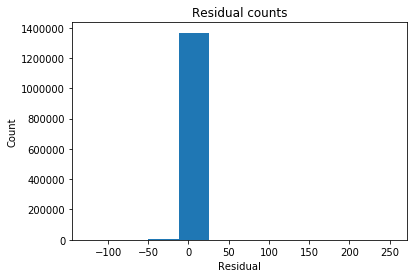

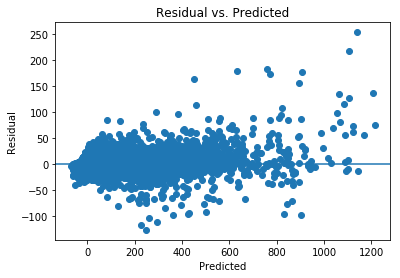

RMSE: 2.8507091201627435


In [31]:
predicted = rfrg.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  
 

In [58]:
param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(6,20),max_features=['sqrt',4,'auto'])
grid = GridSearchCV(rfrg, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 19}
0.9059995063014368


In [59]:
rfrg = ensemble.RandomForestRegressor(criterion='mse',random_state=20, max_features= 'auto',max_leaf_nodes=19,max_depth=4) 
rfrg.fit(X_train,y_train)


print('With 20% Holdout: ' + str(rfrg.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfrg.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(rfrg, X_test, y_test, cv=10))



With 20% Holdout: 0.9454983039100718
Testing on Sample: 0.959472709426474

[0.91015529 0.891812   0.95165518 0.91722896 0.80422173 0.94674568
 0.96969436 0.83385141 0.79114769 0.95532728]


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Support Vector Machine

In [65]:
from sklearn.svm import SVR

# Instantiate our model and fit the data.
svm = SVR(kernel = 'linear')
svm.fit(X_train, y_train)


print('With 20% Holdout: ' + str(svm.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(svm.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(svm, X_test, y_test, cv=10))


With 20% Holdout: 0.954583471947925
Testing on Sample: 0.9548753796184486

[0.97744062 0.92191567 0.96463191 0.94406723 0.86010802 0.96610919
 0.96757602 0.88781326 0.82685043 0.98151151]


In [70]:
param_grid = dict(C=np.arange(.1,5,.1))
grid = GridSearchCV(svm, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'C': 0.4}
0.9440042997770701


In [ ]:
# Instantiate our model and fit the data.
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)

print('With 20% Holdout: ' + str(regr_t.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr_t.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(knn, X_test, y_test, cv=10))


### Gradient boost

In [109]:
from sklearn import ensemble 
 
# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(n_estimators=500,max_depth=2,
                                          loss='ls', random_state=20) 
clf.fit(X_train, y_train)


print('With 20% Holdout: ' + str(clf.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(clf.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(clf, X_test, y_test, cv=10))


With 20% Holdout: 0.9536234556860633
Testing on Sample: 0.9831940998091913

[0.94094351 0.88121867 0.95405254 0.91896371 0.84306729 0.95370319
 0.95443788 0.8025614  0.83978643 0.97036166]


In [110]:
param_grid = dict(n_estimators=np.arange(100,1000,100),max_depth=range(1,8),loss=['ls', 'lad', 'huber', 'quantile'])
grid = GridSearchCV(clf, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'loss': 'lad', 'max_depth': 4, 'n_estimators': 900}
0.9282613089046902


In [111]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(loss='lad', max_depth=4, n_estimators=900,random_state=20) 
clf.fit(X_train, y_train)


print('With 20% Holdout: ' + str(clf.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(clf.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(clf, X_test, y_test, cv=10))



With 20% Holdout: 0.9526719380091636
Testing on Sample: 0.9760385746562613

[0.9327004  0.88738131 0.93486296 0.93493243 0.84890101 0.96501044
 0.95123213 0.88212067 0.8275424  0.94356057]


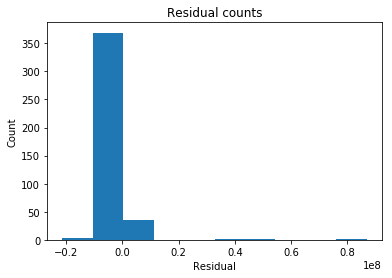

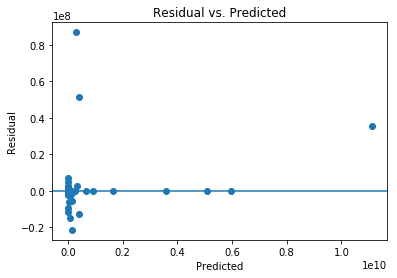

RMSE: 5556674.6340061715


In [107]:
predicted = clf.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  
 

(array([1.599e+03, 2.700e+01, 7.000e+00, 5.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([     0. ,  11628.1,  23256.2,  34884.3,  46512.4,  58140.5,
         69768.6,  81396.7,  93024.8, 104652.9, 116281. ]),
 <a list of 10 Patch objects>)

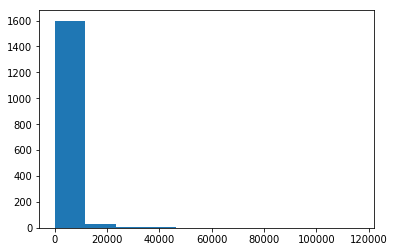

In [99]:
plt.hist(y_train**2)

In [ ]:
from sklearn import preprocessing 
  
# label_encoder object  
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column  
arrivals['seasons']= label_encoder.fit_transform(arrivals['seasons']) 
arrivals['time_of_day']= label_encoder.fit_transform(arrivals['time_of_day']) 
 
print(arrivals['seasons'].unique())
print(arrivals['time_of_day'].unique()) 
